<a href="https://colab.research.google.com/github/Sahar-DataScience/MultiObject_Tracking-StromaVsion/blob/main/EDA_%2B_synthetic_augmentation%2BTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount google drive and change data dir

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/tracking')

## import the data set 

In [ ]:
!wget https://github.com/Stroma-Vision/machine-learning-challenge/releases/download/v0.1/challenge.zip

In [ ]:
!unzip /content/drive/MyDrive/tracking/challenge.zip -d ./data


Archive:  /content/drive/MyDrive/tracking/challenge.zip
   creating: ./data/challenge/
   creating: ./data/challenge/images/
   creating: ./data/challenge/images/test/
  inflating: ./data/challenge/images/test/test.mp4  
   creating: ./data/challenge/images/train/
  inflating: ./data/challenge/images/train/train.mp4  
   creating: ./data/challenge/images/val/
  inflating: ./data/challenge/images/val/val.mp4  
   creating: ./data/challenge/annotations/
  inflating: ./data/challenge/annotations/instances_test.json  
  inflating: ./data/challenge/annotations/instances_train.json  
  inflating: ./data/challenge/annotations/instances_val.json  


## extract training images from train video frames using ffmpeg 
fps = 30

In [ ]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!ffmpeg -i ./data/challenge/images/train.mp4 -s 640x640 -vf fps=30 ./data/challenge/images/train/%04d.jpg


In [ ]:
!ffmpeg -i ./data/challenge/images/val.mp4 -s 640x640 -vf fps=30 ./data/challenge/images/val/%04d.jpg

sanity check on image filenames and annotations

In [ ]:
import glob
from PIL import Image
def correct_filenames(folder_path):
  #make some changes in file names to make it start from 0000.jpg instead of 0001.jpg
  assert folder_path.endswith('/') , 'incorrect path'
  for file_name in glob.glob(folder_path + '/*.jpg'):
    img = Image.open(file_name)
    file_name = file_name.split('/')[-1]
    file_id = int(file_name[:4])
    new_file = folder_path + str(file_id - 1).zfill(4)+'.jpg'
    print(new_file)
    img.save(new_file)

In [ ]:
folder_path = './data/challenge/images/val/'
correct_filenames(folder_path)

## install the detectron2

In [ ]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/16dUGpjMPZ4kPitCWlcc_D9IF8i_SwJFJ/tracking'

### GPU version

In [ ]:
!pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 torchaudio==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!python -m pip install detectron2==0.6 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html

### cpu

In [ ]:
!pip install torch==1.10.1+cpu torchvision==0.11.2+cpu torchaudio==0.10.1 -f https://download.pytorch.org/whl/cpu/torch_stable.html

In [ ]:
!python -m pip install detectron2==0.6 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cpu/torch1.10/index.html

## remove bg module

In [ ]:
!pip install rembg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 KB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 K

## import dependencies 

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0
torch:  1.10 ; cuda:  cu111
detectron2: 0.6


In [ ]:
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer 
from detectron2.utils.colormap import random_color

from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.data.build import print_instances_class_histogram

In [ ]:
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import  json, cv2, random
import glob
from PIL import Image

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# EDA

## register datasets

###Trainset

In [ ]:
register_coco_instances("train_data", {}, 
                        "./data/challenge/annotations/instances_train.json",
                        "./data/challenge/images/train/")

In [ ]:
#DatasetCatalog.clear()

In [ ]:
train_metadata = MetadataCatalog.get("train_data")
print(train_metadata)

Metadata(evaluator_type='coco', image_root='./data/challenge/images/train/', json_file='./data/challenge/annotations/instances_train.json', name='train_data')


In [ ]:
dataset_dicts = DatasetCatalog.get("train_data")
#print(dataset_dicts)

###Valset

In [ ]:
register_coco_instances("val_data", {}, 
                        "./data/challenge/annotations/instances_val.json",
                        "./data/challenge/images/val/")

In [ ]:
val_metadata = MetadataCatalog.get("val_data")
print(val_metadata)

Metadata(evaluator_type='coco', image_root='./data/challenge/images/val/', json_file='./data/challenge/annotations/instances_val.json', name='val_data')


In [ ]:
val_dict = DatasetCatalog.get("val_data")

### sanity check 

In [ ]:
len(dataset_dicts)

7200

In [ ]:
dataset_dicts[0] 

{'file_name': './data/challenge/images/train/0000.jpg',
 'height': 640,
 'width': 640,
 'image_id': 1,
 'annotations': []}

In [ ]:
dataset_dicts[105]

{'file_name': './data/challenge/images/train/0105.jpg',
 'height': 640,
 'width': 640,
 'image_id': 106,
 'annotations': []}

***there are some images with no presented instances, let's extract all their paths***

In [ ]:
basket = []
for i in range(7200):
  if dataset_dicts[i]['annotations'] == []:
    print(dataset_dicts[i]['file_name'])
    basket.append({'iter' : i , 'img_path': dataset_dicts[i]['file_name']})
print(f"number of images with no instances is {len(basket)}") # there are 105 images with no instance

***there are 357 images with no instances. so we stored the rank and the filename path of each zero-instance image***

In [ ]:
print(basket[150])
dataset_dicts[basket[150]['iter']] #in this way we garantee  having access to this images in the data dictionary

{'iter': 1702, 'img_path': './data/challenge/images/train/1702.jpg'}


{'file_name': './data/challenge/images/train/1702.jpg',
 'height': 640,
 'width': 640,
 'image_id': 1703,
 'annotations': []}

***extract dict of only annotaed images***

In [ ]:
only_instances_dict = detectron2.data.get_detection_dataset_dicts("train_data", filter_empty=True, min_keypoints=0, proposal_files=None)
len(only_instances_dict)

6843

## check existing classes

In [ ]:
train_metadata.thing_classes

['bolt', 'nut']

In [ ]:
detectron2.data.print_instances_class_histogram(dataset_dicts, train_metadata.thing_classes)

## Histogram of the two classes

### Histogram Calculation

In [ ]:
#class_names = train_metadata.thing_classes
def show_histogram(class_names, dataset_dicts):
  num_classes = len(class_names)
  hist_bins = np.arange(num_classes + 1)
  histogram = np.zeros((num_classes,), dtype=np.int)
  for entry in dataset_dicts:
      annos = entry["annotations"]
      classes = np.asarray(
          [x["category_id"] for x in annos if not x.get("iscrowd", 0)], dtype=np.int
      )
      if len(classes):
          assert classes.min() >= 0, f"Got an invalid category_id={classes.min()}"
          assert (
              classes.max() < num_classes
          ), f"Got an invalid category_id={classes.max()} for a dataset of {num_classes} classes"
      histogram += np.histogram(classes, bins=hist_bins)[0]
  plt.figure(figsize=[10, 5])
  plt.bar(hist_bins[:-1], histogram, width=0.5, color='blue')
  for index,value in enumerate(histogram):
    plt.text(x=int(index) , y =value,s=f"{value}",fontdict=dict(fontsize=11),ha='left', va='bottom')

  plt.xlim(min(hist_bins), max(hist_bins))
  plt.xticks([0,1], class_names, rotation =0)
  plt.grid(axis='y', alpha=0.75)
  plt.xlabel('classes', fontsize=15)
  plt.ylabel('count', fontsize=15)
  plt.title('Histogram of instances across categories', fontsize=15)

In [ ]:
histogram

array([14787,  3616])

### vizualise the number of instances in each class

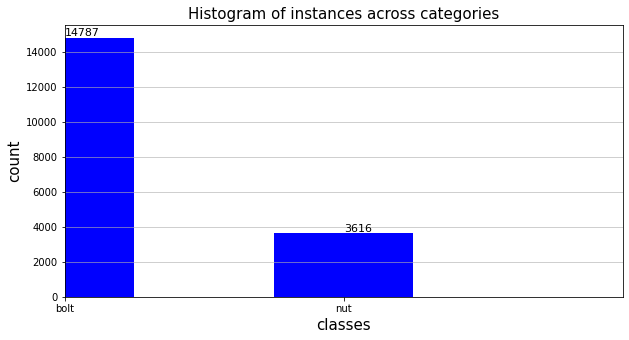

In [ ]:
plt.figure(figsize=[10, 5])
plt.bar(hist_bins[:-1], histogram, width=0.5, color='blue')
for index,value in enumerate(histogram):
  plt.text(x=int(index) , y =value,s=f"{value}",fontdict=dict(fontsize=11),ha='left', va='bottom')

plt.xlim(min(hist_bins), max(hist_bins))
plt.xticks([0,1], class_names, rotation =0)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('classes', fontsize=15)
plt.ylabel('count', fontsize=15)
plt.title('Histogram of instances across categories', fontsize=15)


# Display the chart
plt.show()

***the classes are imbalanced***

<ipython-input-18-15ea1fc3d2be>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  histogram = np.zeros((num_classes,), dtype=np.int)
<ipython-input-18-15ea1fc3d2be>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in N

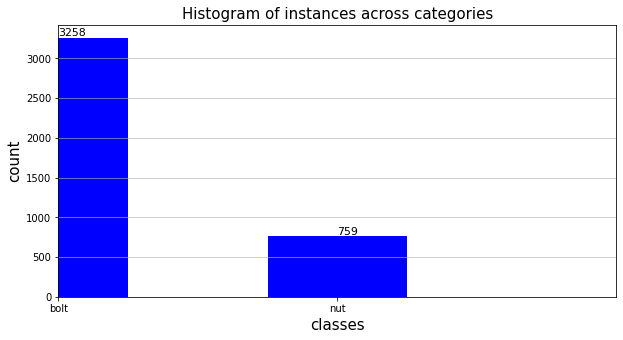

In [ ]:
class_names = val_metadata.thing_classes
show_histogram(class_names, val_dict)

## Vizualise ground truth 

In [ ]:
dataset_dicts[750]

{'file_name': './data/challenge/images/train/0750.jpg',
 'height': 640,
 'width': 640,
 'image_id': 751,
 'annotations': [{'iscrowd': 0,
   'bbox': [539.0, 96.0, 30.0, 94.0],
   'category_id': 0,
   'bbox_mode': <BoxMode.XYWH_ABS: 1>},
  {'iscrowd': 0,
   'bbox': [225.0, 30.0, 35.0, 56.0],
   'category_id': 0,
   'bbox_mode': <BoxMode.XYWH_ABS: 1>},
  {'iscrowd': 0,
   'bbox': [92.0, 137.0, 39.0, 40.0],
   'category_id': 1,
   'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}

In [ ]:
with open("./data/challenge/annotations/instances_train.json","r") as f:
  json_train = json.load(f)

In [ ]:
len(json_train)

5

In [ ]:
json_train.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [ ]:
len(json_train['images'])

7200

In [ ]:
print(f"number of total existing instances is {len(json_train['annotations'])}")
json_train['annotations'][0] # annotations exists starting from frame 107 in which objects starts to be shown

number of total existing instances is 18403


{'image_id': 107,
 'category_id': 1,
 'segmentation': [],
 'bbox': [513.0, 0.0, 91.0, 28.0],
 'area': 2548.0,
 'iscrowd': 0,
 'id': 0,
 'track_id': 1}

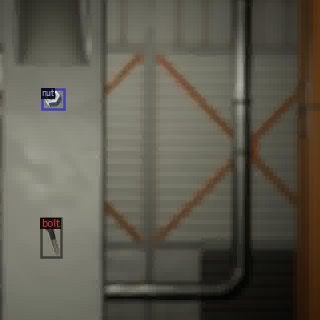

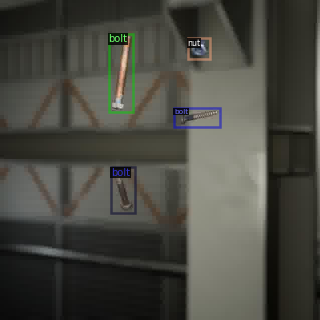

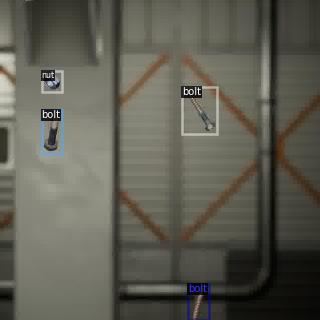

In [ ]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])
    #plt.figure(figsize=(8,8))
    #plt.imshow(out.get_image()[:, :, ::-1])

 ***instances are only annotated with bounding box --> it's object detection problem***

## Synthetically data augmentation 

as there is huge gap between the two imbalanced classes, we will be making targetted augmentation only to the nut category, using the typical DA may increase the instances in both classes but won't reduce the gap which will result a biased model. check this [paper](https://arxiv.org/pdf/2204.03632.pdf).

1. uplod images of nut and remove their background using [rembg](https://github.com/danielgatis/rembg) and save it in png format. (foregrounds).

2. chosing 15 coordinates where the nuts foreground will be placed seperatelly on the existed empty frames in the training set.

3. update the annotations dict of these frames in the trainset dict.

mesuring the size of the nut in an image in order to resize the foreground with the same size

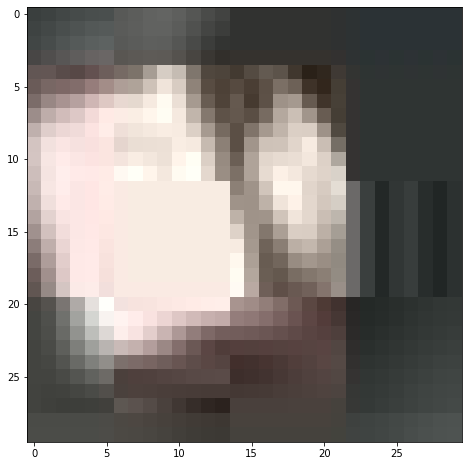

In [ ]:
#im = Image.open(dataset_dicts[5800]['file_name'])
#display(im)
img1 = cv2.imread(dataset_dicts[5800]['file_name'])
#cv2_imshow(img1)
plt.figure(figsize=(8,8))
plt.imshow(img1[300:330,90:120,:])

In [ ]:
img1[300:330,90:120,:].shape

(30, 30, 3)

background removal using [rembg](https://github.com/danielgatis/rembg)

In [ ]:
from rembg import remove

In [ ]:
nut = Image.open('./data/good3.jpg')
nut_fg = remove(nut).convert('RGBA').resize((30,30))
display(nut_fg)
nut_fg.save('./data/good3.png')

In [ ]:
for file_path in  glob.glob('./data/*.png') : 
  nut = Image.open(file_path)
  nut_fg = remove(nut).convert('RGBA').resize((30,30))
  display(nut_fg)
  nut_fg.save(file_path)

###synthetise(fg_path, bg_path)

In [ ]:
from detectron2.structures import BoxMode

def synthetise(bg_path):
  # a function that will paste nut fg on empty frame and return the correponding annotation
  coord = [(500,200),(500,50),(300,300),(400,350),(20,70),(120,560),(560,560),(40,20),(420,420),(150,50),(50,150),(100,200),(200,100),(300,500),(500,300)]
  bg_img = Image.open(bg_path)
  i=0
  j=0
  instance_dict = []
  for fg_path in glob.glob('./data/*.png'):
    i+=5
    nut_fg = Image.open(fg_path)
    nut_fg = nut_fg.resize((40,40))
    h, w = nut_fg.size
    for tup  in coord[j:i]:
      bg_img.paste(nut_fg,box=tup, mask = nut_fg)
      
      instance_dict.append({'iscrowd': 0, 
                            'bbox': [float(tup[0]), float(tup[1]), float(w), float(h)], 
                            'category_id': 1, 
                            'bbox_mode': BoxMode.XYWH_ABS})
    j+=5
  
  return instance_dict , np.array(bg_img)

###making synthetic data and storing it 

In [ ]:
from detectron2.structures import BoxMode
from tqdm import tqdm

for d in tqdm(basket):
  obj , img = synthetise(d['img_path'])
  dataset_dicts[d['iter']]['annotations'] += obj 
  Image.fromarray(img).save(d['img_path'])
  #dataset_dicts[d['iter']]

checking the result visually 

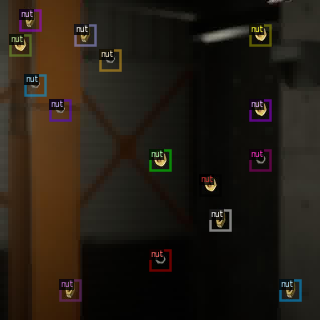

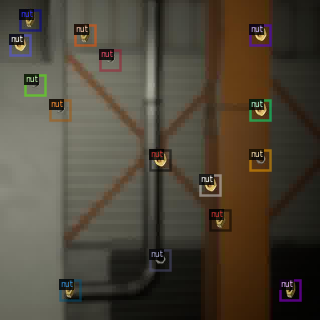

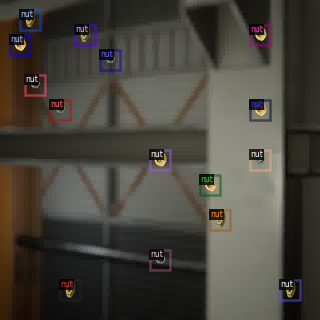

In [ ]:
for d in random.sample(basket, 3):
  img = cv2.imread(dataset_dicts[d['iter']]['file_name'])
  visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
  out = visualizer.draw_dataset_dict(dataset_dicts[d['iter']])
  cv2_imshow(out.get_image()[:, :, ::-1])

dump the new trainset annotation dict in json file

In [ ]:
with open("./data/augmented_data.json",'w') as g:
  json.dump(dataset_dicts,g)

### Histogram of instances after aumendting the data 

<ipython-input-139-c018c9a90b72>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  histogram = np.zeros((num_classes,), dtype=np.int)
<ipython-input-139-c018c9a90b72>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in

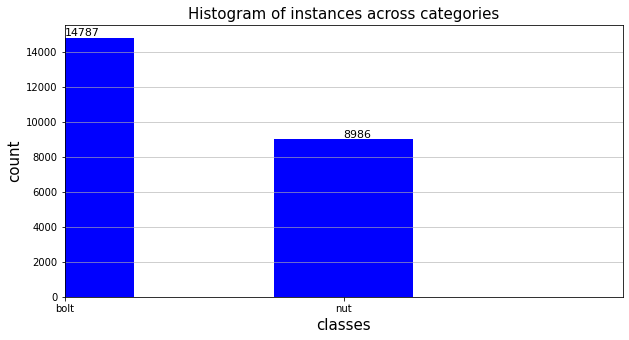

In [ ]:
show_histogram(class_names, dataset_dicts)

###register the new tarin data dict in detectron2 datasets

In [ ]:
def get_dataset_dicts(p):
  with open(p+".json","r") as f:
    data_dict = json.load(f)
  return data_dict

In [ ]:
DatasetCatalog.clear()

In [ ]:
path= "/content/drive/MyDrive/tracking/data/"
for d in  ["data"]:
  DatasetCatalog.register(d+"_train", lambda d=d: get_dataset_dicts(path + d))
  MetadataCatalog.get(d+"_train").set(thing_classes=['bolt', 'nut'])

In [ ]:
train_metadata = MetadataCatalog.get("data_train")

In [ ]:
train_metadata

Metadata(name='data_train', thing_classes=['bolt', 'nut'])

In [ ]:
train_dict = DatasetCatalog.get("data_train")


In [ ]:
len_dataset = len(train_dict) + len(val_dict)
len_dataset

9000

#Training

##Trainer configs
updating the max iteration's steps, backbone layers,  (thttps://detectron2.readthedocs.io/en/latest/modules/config.html#yaml-config-references)

In [ ]:
cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/tracking/logs"

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  
cfg.DATASETS.TRAIN = ("data_train","val_data")

cfg.DATALOADER.NUM_WORKERS = 4

cfg.SOLVER.BASE_LR = 0.001  # pick a good LR

cfg.SOLVER.MAX_ITER = 180000 #9000*20epochs

cfg.SOLVER.STEPS = (60000,) # The iteration number to decrease learning rate by GAMMA (*0.1).
cfg.SOLVER.gamma = 0.5
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.CHECKPOINT_PERIOD = 9000 #  each 1 epoch = 8812 iterations, the model will be saved

cfg.MODEL.RETINANET.NUM_CLASSES = 2


#os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
cfg.MODEL.DEVICE = "cuda"

##Launch the training

[02/17 12:01:59 d2.data.datasets.coco]: Loaded 1800 images in COCO format from ./data/challenge/annotations/instances_val.json
[02/17 12:01:59 d2.data.build]: Removed 188 images with no usable annotations. 8812 images left.
[02/17 12:01:59 d2.data.build]: Distribution of instances among all 2 categories:

|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    bolt    | 18045        |    nut     | 9745         |
|            |              |            |              |
|   total    | 27790        |            |              |

In [ ]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[02/17 12:01:59 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_5bd44e.pkl: 152MB [00:03, 50.1MB/s]                           
head.cls_score.{bias, weight}
  pixel_mean
  pixel_std


[02/17 12:02:12 d2.engine.train_loop]: Starting training from iteration 0
[02/17 12:03:26 d2.utils.events]:  eta: 2 days, 4:22:45  iter: 19  total_loss: 1.646  loss_cls: 1.255  loss_box_reg: 0.3993  time: 1.0839  data_time: 2.6111  lr: 1.9981e-05  max_mem: 2168M
[02/17 12:03:42 d2.utils.events]:  eta: 2 days, 1:07:24  iter: 39  total_loss: 1.257  loss_cls: 0.951  loss_box_reg: 0.3217  time: 0.9271  data_time: 0.0189  lr: 3.9961e-05  max_mem: 2168M
[02/17 12:03:56 d2.utils.events]:  eta: 1 day, 13:49:55  iter: 59  total_loss: 1.286  loss_cls: 0.9959  loss_box_reg: 0.2632  time: 0.8528  data_time: 0.0132  lr: 5.9941e-05  max_mem: 2168M
[02/17 12:04:11 d2.utils.events]:  eta: 1 day, 13:40:08  iter: 79  total_loss: 1.195  loss_cls: 0.967  loss_box_reg: 0.2487  time: 0.8253  data_time: 0.0139  lr: 7.9921e-05  max_mem: 2168M
[02/17 12:04:25 d2.utils.events]:  eta: 1 day, 13:31:05  iter: 99  total_loss: 0.703  loss_cls: 0.5561  loss_box_reg: 0.144  time: 0.8018  data_time: 0.0141  lr: 9.9901e